In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import re
import datetime
import pandas as pd
import seaborn as sns

from pymongo import MongoClient

In [3]:
database = 'davide'
collection = 'es_tweets'

client = MongoClient('localhost', 27017)
db = client[database]
print ("server version:", client.server_info()["version"])

server version: 4.2.5


In [4]:
def words_match_regex(words_list):
    words_regex_objs = []
    for wd in words_list:
        regex_wd = '.*{}.*'.format(wd)
        words_regex_objs.append(re.compile(regex_wd, re.IGNORECASE))
    return(words_regex_objs)

In [5]:
def time_to_sec(hhmmss):
        [hours, minutes, seconds] = [int(x) for x in hhmmss.split(':')]
        x = datetime.timedelta(hours=hours, minutes=minutes, seconds=seconds)
        return(x.seconds/86400)

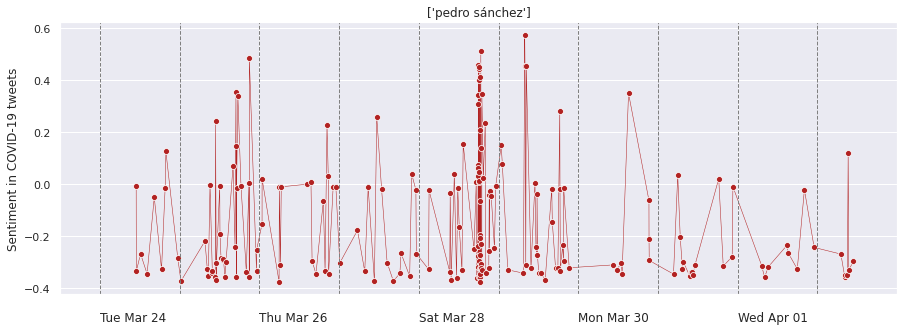

In [7]:
words = ['pedro sánchez']
pipeline = { 'text': { '$in': words_match_regex(words) } }

lst = []
for doc in db[collection].find(pipeline):
    try:
        lst.append([doc['sentiment']['score'],doc['created_at']])
    except:
        pass

df = pd.DataFrame.from_records(lst).dropna()
df.columns = ['sentiment','date']
df[['weekday','month','day','time','r1','r2']] = df['date'].str.split(' ',expand=True)
sorter = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
sorterIndex = dict(zip(sorter,range(len(sorter))))
df['weekday_id'] = df['weekday'].map(sorterIndex)

sorter = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sorterIndex = dict(zip(sorter,range(len(sorter))))
df['month_id'] = df['month'].map(sorterIndex)

df = df.sort_values(by=['month_id', 'day', 'weekday_id', 'time'])

df['date_simple'] = df['weekday']+" "+df['month']+" "+df['day']

sorter = df['date_simple'].unique()
sorterIndex = dict(zip(sorter,range(len(sorter))))
df['time_id'] = [ time_to_sec(i) for i in df['time'] ]
df['time_axis'] = df['date_simple'].map(sorterIndex)+df['time_id']

df = df.sort_values(by='time_axis',ascending=True)
df.drop(['weekday','month','day','time','r1','r2','weekday_id','month_id','time_id'], axis=1, inplace=True)

sns.set(rc={'figure.figsize':(15, 5)})
ax = sns.lineplot(x="time_axis", y="sentiment", data=df, linewidth=0.5, marker='o', linestyle='-', color='firebrick')
ax.set_xticklabels('')
ax.set_xlim(-0.5,len(df['date_simple'].unique()))
ax.set_ylabel('Sentiment in COVID-19 tweets')
ax.set_xlabel('')
ax.set_title(words)
for c,v in enumerate(df['date_simple'].unique()):
    plt.axvline(c, 0, 1,color='grey', linestyle='dashed', linewidth=1)
for i in list(ax.get_xticks())[1:-1]:
    lab = df['date_simple'].unique()[int(i)]
    plt.text(i,min(df['sentiment'])-0.15,lab)
